## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==1.0.0


In [2]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from datetime import datetime
import pytz
import time
import numpy as np
import random

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=102, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=102)
testloader = torch.utils.data.DataLoader(test_data, batch_size=102)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [29]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(len(cat_to_name), '\n', cat_to_name)

102 
 {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '5

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [29]:
# TODO: Build and train your network

#Get the pretrained model and check the characteristics of the classifier
model = models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 237MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
# Freeze parameters in the pre-trained model so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [31]:
#update the classifier of the pre-trained model with a classifier that has 102 outputs and softmax function
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.2, inplace=False)),
                                        ('fc2', nn.Linear(4096, 102)),
                                        ('output', nn.LogSoftmax(dim=1))
                                       ])) 
    
model.classifier = classifier #last line in model calls this "fc"


# model.classifier._modules['6'] = nn.Linear(4096, 102)
# model.classifier._modules['7'] = nn.LogSoftmax(dim=1)

#check that the model classifier has been updated
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [96]:
#Now time to train the model

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

#set Variables for training
epochs = 1
training_steps = 0
training_loss = 0
validate_every = 5 #how often validation is done i.e. every <validate_every> batches

for epoch in range(epochs):
    for images, labels in trainloader:
        start = time.time()
        training_steps += 1
        
        #move image and label to device
        images, labels = images.to(device), labels.to(device)
        
        #perform training steps
        #optimiser gradient will accumulate so set to zero before calculating gradients each time
        optimizer.zero_grad()
        #find raw probabilities log is used here because output is an exponent (softmax)
        logps = model(images)
        #Calculate loss overall
        loss = criterion(logps, labels)
        #calculate gradients for all parameters
        loss.backward()
        #Update parameters  
        optimizer.step()
        
        training_loss += loss.item()
        
        #perform validation every <validate_every> batches
        if training_steps % validate_every == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0
            
            #disable autograd for validation - gradients do not need to be calculated
            with torch.no_grad():
                #perform validation loop on each batch in the validation loader
                for images, labels in validationloader:

                    #move image and label to device
                    images, labels = images.to(device), labels.to(device)

                    logps = model(images)
                    loss = criterion(logps, labels) #find the loss for this batch
                    validation_loss += loss.item() #sum losses for all batches

                    #calculate accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim = 1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor))
            
            with open('classifier_results.txt', 'a') as f:
                f.write(f"\nDevice = {device} \n \
                Date: {datetime.now(pytz.timezone('Pacific/Auckland'))} \n \
                Time for this batch: {(time.time() - start)/3:.3f} seconds \n \
                Epoch: {epoch + 1}/{epochs} \n \
                Batch: {training_steps}/{len(trainloader)} \n \
                Training Loss: {training_loss/validate_every:.3f} \n \
                Validation Loss: {validation_loss/len(validationloader):.3f} \n \
                Validation Accuracy: {accuracy/len(validationloader):.3f} \n")
            
            print(f"Device = {device} ",
                  f"Time for this batch: {(time.time() - start)/3:.3f} seconds ",
                  f" Epoch: {epoch + 1}/{epochs} ",
                  f" Batch: {training_steps}/{len(trainloader)} ",
                  f"Training Loss: {training_loss/validate_every:.3f} ",
                  f"Validation Loss: {validation_loss/len(validationloader):.3f} ", #divide by number of batches to see average los
                  f"Validation Accuracy: {accuracy/len(validationloader):.3f}") #divide by number of batches to see average accuracy
            
            training_loss = 0
            model.train()

Device = cuda  Time for this batch: 64.767 seconds   Epoch: 1/1   Batch: 5/65  Training Loss: 1.473  Validation Loss: 0.868  Validation Accuracy: 0.783
Device = cuda  Time for this batch: 64.567 seconds   Epoch: 1/1   Batch: 10/65  Training Loss: 1.645  Validation Loss: 0.945  Validation Accuracy: 0.770
Device = cuda  Time for this batch: 70.865 seconds   Epoch: 1/1   Batch: 15/65  Training Loss: 1.538  Validation Loss: 0.973  Validation Accuracy: 0.776
Device = cuda  Time for this batch: 70.900 seconds   Epoch: 1/1   Batch: 20/65  Training Loss: 1.767  Validation Loss: 0.937  Validation Accuracy: 0.757
Device = cuda  Time for this batch: 68.967 seconds   Epoch: 1/1   Batch: 25/65  Training Loss: 1.807  Validation Loss: 0.864  Validation Accuracy: 0.773
Device = cuda  Time for this batch: 70.133 seconds   Epoch: 1/1   Batch: 30/65  Training Loss: 1.813  Validation Loss: 0.873  Validation Accuracy: 0.775
Device = cuda  Time for this batch: 70.233 seconds   Epoch: 1/1   Batch: 35/65  Tra

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [98]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
testing_steps = 0

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
model.eval()

with torch.no_grad():
    #perform validation loop on each batch in the validation loader
    for images, labels in testloader:
        testing_steps += 1
        
        #move image and label to device
        images, labels = images.to(device), labels.to(device)

        logps = model(images)
        loss = criterion(logps, labels) #find the loss for this batch
        test_loss += loss.item() #sum losses for all batches

        #calculate accuracy for each batch
        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim = 1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor))
        
        print(f"Test batch: {testing_steps}/{len(testloader)} ",
              f"Test loss: {test_loss/testing_steps:.3f} ", #divide by number of test batches to see average test loss
              f"Test accuracy: {accuracy/testing_steps:.3f}") #divide by number of test batches to see average test accuracy

Test batch: 1/9  Test loss: 1.178  Test accuracy: 0.706
Test batch: 2/9  Test loss: 1.137  Test accuracy: 0.706
Test batch: 3/9  Test loss: 1.199  Test accuracy: 0.696
Test batch: 4/9  Test loss: 1.077  Test accuracy: 0.728
Test batch: 5/9  Test loss: 1.059  Test accuracy: 0.731
Test batch: 6/9  Test loss: 0.914  Test accuracy: 0.770
Test batch: 7/9  Test loss: 1.000  Test accuracy: 0.749
Test batch: 8/9  Test loss: 1.055  Test accuracy: 0.739
Test batch: 9/9  Test loss: 0.938  Test accuracy: 0.768


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [99]:
# TODO: Save the checkpoint 
epochs = 1

#add the class to indices map
model.class_to_idx = cat_to_name

#check mapping has been added
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

checkpoint = {'architecture': 'vgg16',
              'classifier': model.classifier,
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epochs': epochs             
             }

torch.save(checkpoint, 'checkpoint.pth')

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [7]:
def load_checkpoint(filepath):
    # Load checkpoint
    checkpoint = torch.load(filepath)
    
    # Rebuild the model
    model = getattr(models, checkpoint['architecture'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    
    # Load state dictionary
    model.load_state_dict(checkpoint['state_dict'])
      
    # Attach mapping of classes to indices
    model.class_to_idx = checkpoint['class_to_idx']
    
    #initialise and rebuild the optimiser
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model

# usage:
model = load_checkpoint('checkpoint.pth')
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 290MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
#check the weights and biases in the classifier
for name, param in model.classifier.named_parameters():
    print(name, param)
    
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

fc1.weight Parameter containing:
tensor([[ 0.0250,  0.0243,  0.0225,  ...,  0.0084, -0.0252, -0.0173],
        [-0.0132, -0.0027, -0.0010,  ..., -0.0200, -0.0300, -0.0181],
        [ 0.0175, -0.0010, -0.0194,  ..., -0.0229, -0.0187, -0.0189],
        ...,
        [-0.0105, -0.0180, -0.0152,  ..., -0.0070, -0.0104, -0.0071],
        [-0.0284, -0.0241, -0.0219,  ..., -0.0180, -0.0192, -0.0199],
        [ 0.0219, -0.0053, -0.0185,  ..., -0.0317, -0.0130,  0.0084]],
       device='cuda:0', requires_grad=True)
fc1.bias Parameter containing:
tensor([-0.0141, -0.0150, -0.0123,  ..., -0.0173, -0.0282, -0.0187],
       device='cuda:0', requires_grad=True)
fc2.weight Parameter containing:
tensor([[ 2.0202e-02,  2.1143e-02,  3.3574e-02,  ...,  1.6005e-02,
          3.3975e-02,  1.1954e-02],
        [-4.6297e-03,  9.0831e-03, -1.8483e-02,  ..., -2.5819e-02,
         -2.4226e-02,  2.0940e-02],
        [-2.5924e-03,  2.8867e-02, -1.6461e-02,  ..., -2.1175e-02,
          2.8474e-02, -2.5603e-02],
   

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [9]:
# TODO: Process an image for use in a PyTorch model
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Open the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize((256, 256))
    
    # Centre crop the image
    left = (256 - 224) / 2
    top = (256 - 224) / 2
    right = left + 224
    bottom = top + 224
    image = image.crop((left, top, right, bottom))
    
    # Convert to a NumPy array
    np_image = np.array(image)
        
    # Normalize the image
    # normalise colour channel from 0-255 to 0-1
    np_image = np_image / 255.0
    # normalise image using mean and standard deviation of ImageNet dataset
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # transpose color channel from the last dimension (H x W x C) to the first dimension (C x H x W) for Pytorch
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [10]:
#check processed image will transform back to a visible image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension so need to transpose
    image = image.transpose((1, 2, 0))
    
    # Undo mean and std dev normalising
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<Axes: >

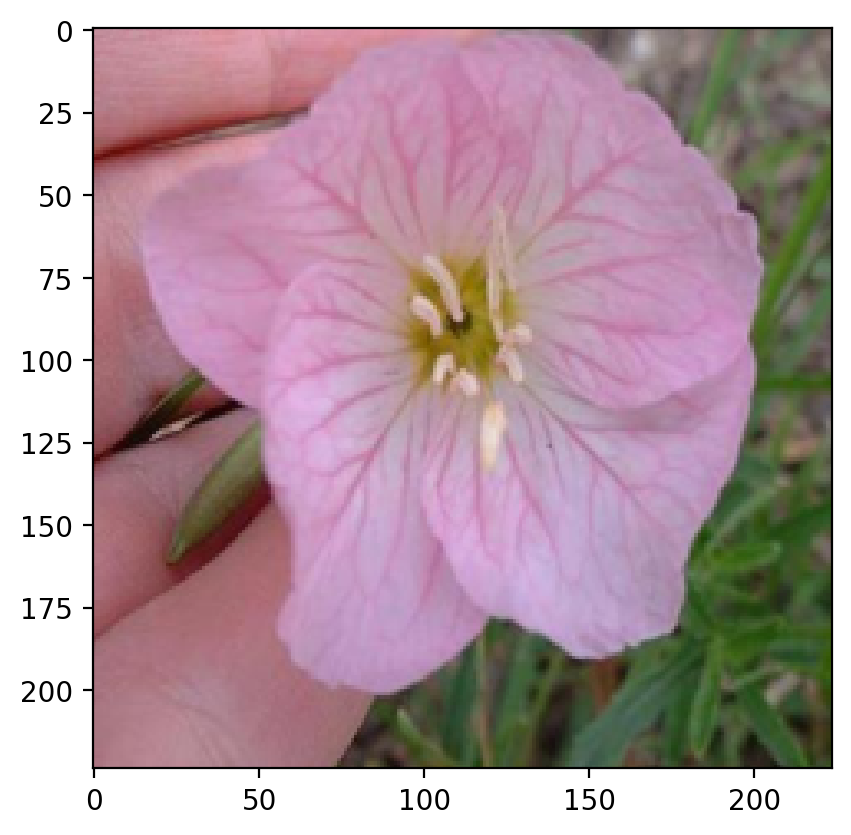

In [11]:
from PIL import Image 
#check processed image code works by transforming then performing an inverse and displaying image
image_path = test_dir +'/1/image_06754.jpg'
processed_image = process_image(image_path)
imshow(processed_image)

In [19]:
# WHY NOT USE PYTORCH TRANSFORMS GIVEN THAT: A) PILLOW  HAS NOT BEEN PART OF ANY LESSONS, AND
# B) THE PYTORCH TRANSFORMS CODE DOES THE SAME JOB WITH FEWER LINES? 

"""def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process an image for use in a PyTorch model
    image_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
    
    image = image_transforms(image)
        
    return image"""

"def process_image(image_path):\n    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,\n        returns an Numpy array\n    '''\n    \n    # TODO: Process an image for use in a PyTorch model\n    image_transforms = transforms.Compose([transforms.Resize(256),\n                                         transforms.CenterCrop(224),\n                                         transforms.ToTensor(),\n                                         transforms.Normalize([0.485, 0.456, 0.406],\n                                                              [0.229, 0.224, 0.225])])\n    \n    image = image_transforms(image)\n        \n    return image"

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [70]:
# TODO: Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #convert image to numpy array and normalise
    image = process_image(image_path)   
    
    # Use GPU if it's available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert the NumPy array to a PyTorch tensor and move to device
    image_tensor = torch.tensor(image)
    image_tensor = image_tensor.to(device)
    
    #format tensor so that it can be used by the model 
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.float()
   
    #turn off drop out
    model.eval()    

    #run the model with no gradient descent
    with torch.no_grad():
        logps = model(image_tensor)
        
    #get top classes for this image
    probs = torch.exp(logps)
    
    top_probs, top_classes = probs.topk(topk, dim = 1)  
    
    #convert class indices to flower names and store as a list for matplotlib   
    flower_names = [ model.class_to_idx.get(str(flower_idx)) for flower_idx in top_classes[0].tolist() ]
            
    #convert top probabilities to a list for matplotlib
    top_probs = top_probs[0].tolist()
    
    """##Udacity suggested code - causes errors:
    top_indices = np.array(ps[1][0].cpu().numpy())
    idx_to_class = {x: y for y, x in class_to_idx.items()}
    top_classes = [idx_to_class[x] for x in top_indices]"""
    
    return top_probs, flower_names  

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [71]:
# Get random image
# Pick random flower
random_flower_idx = random.choice(os.listdir(test_dir))
print(random_flower_idx)

# determine actual flower name from the directory name
actual_flower_name = cat_to_name[random_flower_idx]
print(actual_flower_name)

# pick random file from the randmly chosen flower directory
image_filename = random.choice(os.listdir(test_dir + "/" + random_flower_idx))
print(image_filename)

#create image path ready for prediction
image_path = test_dir + "/" + random_flower_idx + "/" + image_filename
print(image_path)

46
wallflower
image_01125.jpg
flowers/test/46/image_01125.jpg


In [72]:
#run code to find top probable flower names for an image
top_probs, flower_names = predict(image_path, model)
#lower_names, top_probs = format_results(probs, classes, model)
print(classes)
print (flower_names)
print (top_probs)
print (flower_names[0])

tensor([[89, 36, 78, 97, 35]], device='cuda:0')
['sword lily', 'petunia', 'sunflower', 'oxeye daisy', 'canterbury bells']
[0.9999949932098389, 5.048662387707736e-06, 3.7526266538634445e-08, 1.934016857774168e-08, 1.0250915671861094e-08]
sword lily


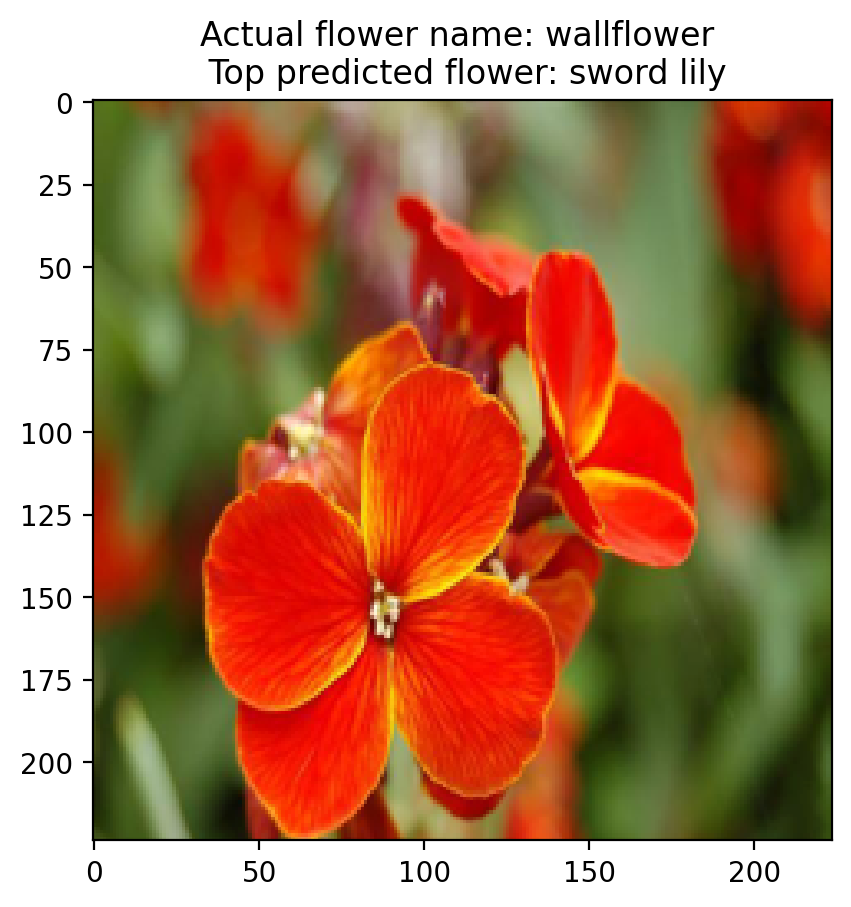

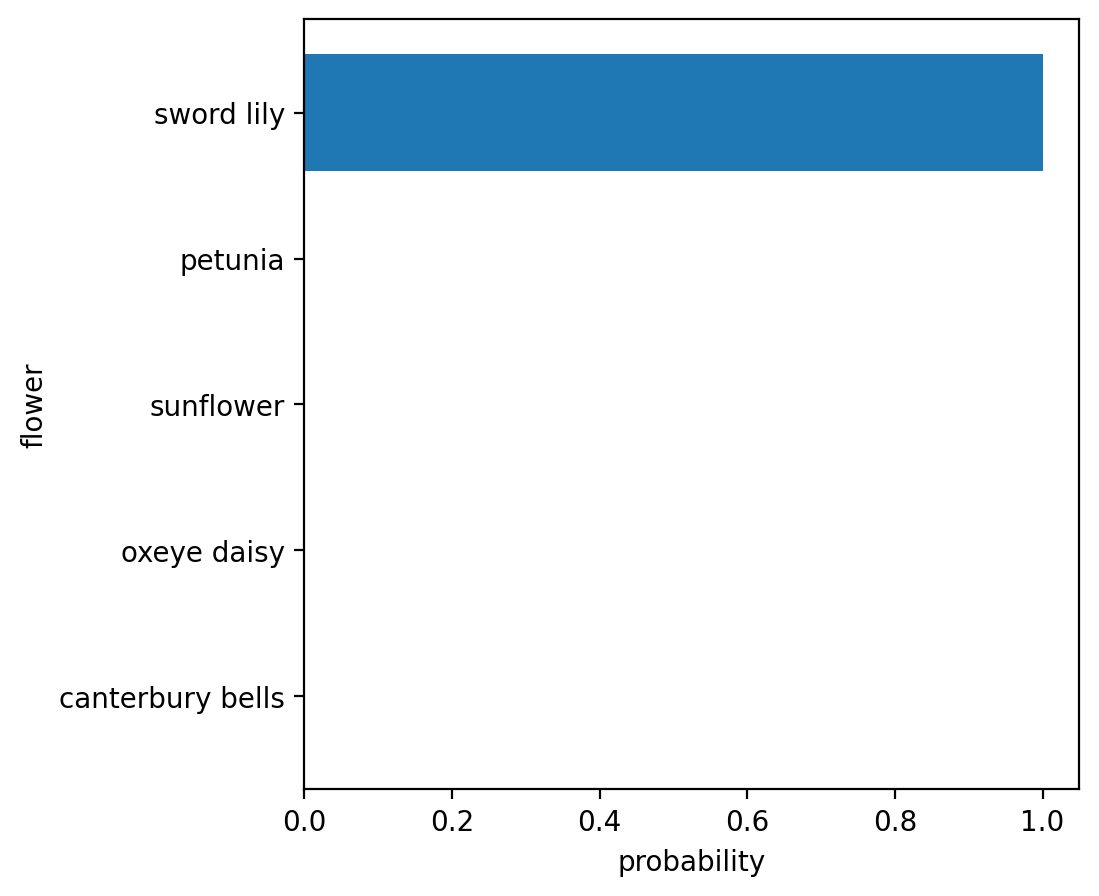

In [73]:
#display the image
processed_image = process_image(image_path)
imshow(processed_image)
plt.title(f"Actual flower name: {actual_flower_name} \n Top predicted flower: {flower_names[0]}")

#display graph of top 5 probable names
# define x and y values 
x = flower_names
y = top_probs

# Set graph size
plt.figure(figsize=(5, 5))

#create horizontal bar graph
plt.barh(x, y)

# Label the axes
plt.ylabel('flower')
plt.xlabel('probability')

#show top prediction at top
plt.gca().invert_yaxis()

# Dsiplay the plot
plt.show()

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [24]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace